In [2]:
import gzip
import json
import re
import os
import sys
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from collections import defaultdict
import tensorflow as tf
import altair as alt
import collections

pd.set_option('display.max_colwidth', 100) 

from src.utils import split_dataframe, CFModel, book_neighbors
from src.load_data import read_tables
from src.DNN_Model import generate_dataset, build_dnn_model, make_shared_embedding_col, make_embedding_col

### load reviews and books data

In [3]:
reviews = pd.read_csv('data/cleaned_reviews_mystery_1.csv')
books = pd.read_csv('data/cleaned_books_mystery_1.csv')
books.sort_values(by='book_id', inplace=True)

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551765 entries, 0 to 1551764
Data columns (total 9 columns):
review_id      1551765 non-null object
user_id        1551765 non-null int64
book_id        1551765 non-null int64
rating         1551765 non-null int64
timestamp      1551765 non-null object
n_votes        1551765 non-null int64
n_comments     1551765 non-null int64
old_user_id    1551765 non-null object
old_book_id    1551765 non-null int64
dtypes: int64(6), object(3)
memory usage: 106.6+ MB


In [29]:
reviews.head(2)

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
0,d23dc89ab32cd864e54d18369751163b,102489,37120,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084
1,c7613da4cbd48baa83efec99b4dd6a41,102489,96299,3,2001-01-11 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,79030


In [5]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105365 entries, 0 to 105364
Data columns (total 12 columns):
book_id               105365 non-null int64
title                 105365 non-null object
num_pages             105365 non-null int64
is_ebook              105365 non-null int64
link                  105365 non-null object
average_rating        105365 non-null float64
ratings_count         105365 non-null int64
text_reviews_count    105365 non-null int64
author_id             105365 non-null int64
publisher             76004 non-null object
similar_books         105365 non-null object
old_book_id           105365 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 9.6+ MB


In [30]:
books.head(2)

,book_id,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books,old_book_id
0,75512,The House of Memory (Pluto's Snitch #2),318,1,https://www.goodreads.com/book/show/33394837-t...,4.33,269,60,242185,NaN,[],33394837
1,35550,"Dead in the Morning (Patrick Grant, #1)",0,0,https://www.goodreads.com/book/show/1902202.De...,3.3,52,8,190988,Ulverscroft,[],1902202


### generate data for dnn model

input layer: previously liked book, previously disliked book, book content features (here only include 'author_id')

In [3]:
# one-time code to generate dataset for dnn model, then save to pickle file

# dataset = generate_dataset(reviews, books, min_good_rating =4, max_num_books_per_user=20) # processed 1551000 rows
#dataset.to_pickle('data/dnn_dataset_w_books.pkl')

In [4]:
# read saved dnn-ready data

dataset = pd.read_pickle('data/dnn_dataset_w_books.pkl')

In [5]:
dataset.tail(2)

,user_id,book_id,rating,timestamp,author_id,prev_good_books,prev_bad_books
1551763,34243,78523,5,2017-11-03 21:12:55,202905,"[55927, 47953, 44562, 61742, 68857, 55357, 60698, 58912, 52707, 47098, 56919, 52697, 57143, 4422...",[]
1551764,71677,82113,3,2017-11-03 22:17:08,3936,"[46538, 83396, 13821]",[22731]


### build model

#### constraint to 2 previously liked and disliked books

    * author_id, no regularization
    * author_id, regularization
    * no author_id, no regularization
    * no author_id, regularization

In [6]:
#constraint to two previously liked and disliked books to speed up iteration

dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: x[:2])
dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: x[:2])

* author_id, no regularization

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3
build_dnn_model#4 calculate train/test loss
_train_init
_train_init done
 iteration 10000: train_loss=2.535836, test_loss=5.912593
time spent for the process is 159.62041 seconds


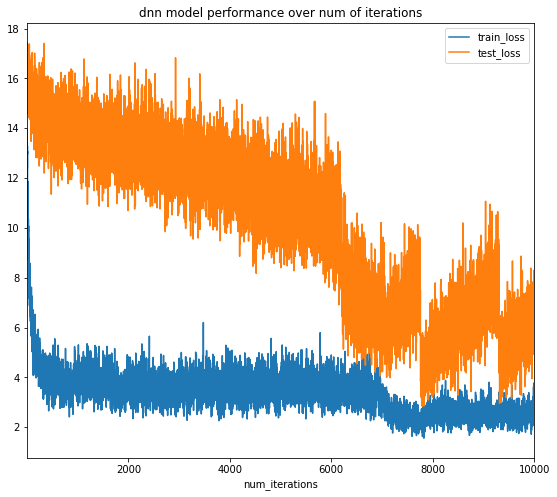

In [17]:
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) + [
            make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model_1 = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1
    )
    
start_time = timeit.default_timer()
dnn_model_1.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.

build_dnn_model#4 calculate train/test loss
_train_init
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
_train_init done
 iteration 7000: train_loss=2.7666

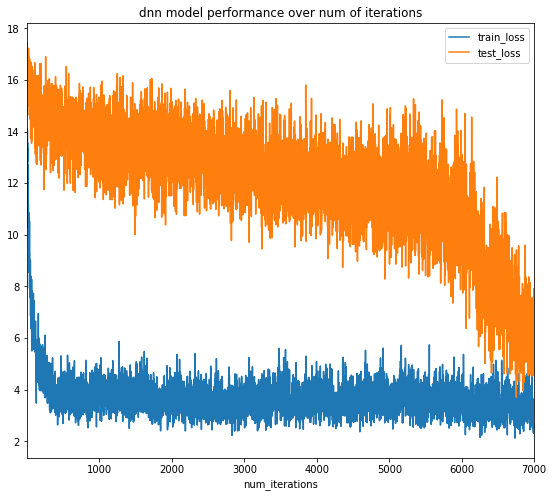

In [8]:
# author_id, no regularization, num_iteration =7000
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) + [
            make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model_6 = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1
    )
    
start_time = timeit.default_timer()
dnn_model_6.train( num_iterations =7000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

 iteration 500: train_loss=2.124785, test_loss=6.9774742
time spent for the process is 94.98190 seconds


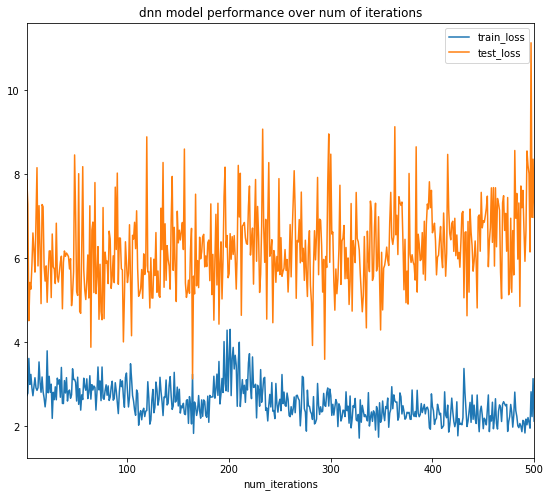

In [9]:
start_time = timeit.default_timer()
dnn_model_6.train( num_iterations =500)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

* author_id, regularization = 0.1

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3
build_dnn_model#4 calculate train/test loss
_train_init
_train_init done
 iteration 10000: train_loss=3.688284, test_loss=8.716819
time spent for the process is 2212.06476 seconds


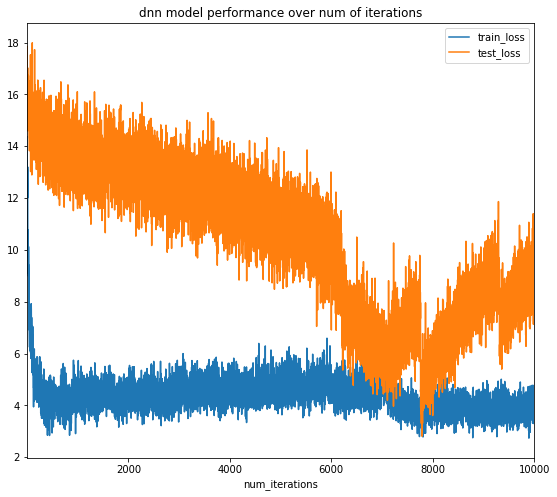

In [100]:
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) + [
            make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model_5 = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1, regularization_coeff = 0.1
    )
    
start_time = timeit.default_timer()
dnn_model_5.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

* no author_id, no regularization

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3
build_dnn_model#4 calculate train/test loss
_train_init
_train_init done
 iteration 10000: train_loss=3.223876, test_loss=4.131045
time spent for the process is 2245.12547 seconds


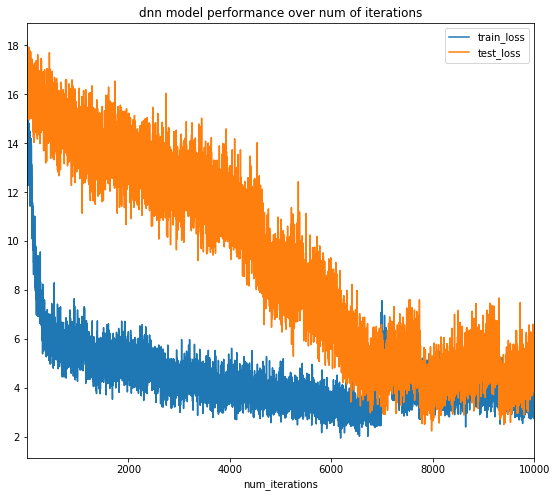

In [99]:
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) 
             # + [make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model_4 = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1, regularization_coeff = 0
    )
    
start_time = timeit.default_timer()
dnn_model_4.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

* no author_id, regularization = 0.1

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3
build_dnn_model#4 calculate train/test loss
_train_init
_train_init done
 iteration 10000: train_loss=4.885419, test_loss=9.217759
time spent for the process is 2177.42523 seconds


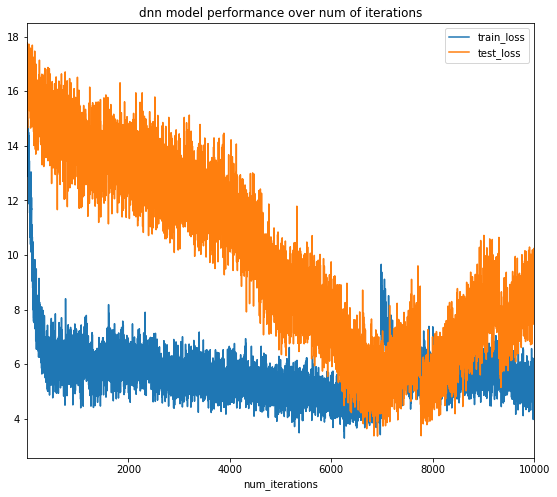

In [34]:
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) 
             # + [make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model_3 = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1, regularization_coeff = 0.1
    )
    
start_time = timeit.default_timer()
dnn_model_3.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

#### save book embedding for book recommendation

In [ ]:
# save model_embeddings
np.savez('model/model_reg_embeddings.npz', model_reg.embeddings['user_id'], model_reg.embeddings['book_id'])

# load model_embeddings

# file = np.load('model/model_reg_embeddings.npz')
# user_embeddings = file['arr_0']
# book_embeddings = file['arr_1']

## get recommendations!

In [59]:
# get k recommendations by giving a title_substring of your favorate mystery/crime book

title_substring = 'Da Vinci Code'
k = 10
neighbors_df_1 = book_neighbors(books, dnn_model_6, title_substring, measure='cosine', k=k)

Nearest neighbors of : 98520    The Da Vinci Code (Robert Langdon, #2)
Name: title, dtype: object.


,cosine score,book_id,titles,average_rating,ratings_count,link
98520,1.0,104081,"The Da Vinci Code (Robert Langdon, #2)",3.79,1465770,https://www.goodreads.com/book/show/968.The_Da_Vinci_Code
32408,0.9973204135894775,87986,"The Crossing Places (Ruth Galloway, #1)",3.87,29,https://www.goodreads.com/book/show/6268634-the-crossing-places
61882,0.9966592788696289,10213,Death in Perugia: The Definitive Account of the Meredith Kercher Case from Her Murder to the Acq...,3.71,137,https://www.goodreads.com/book/show/12817086-death-in-perugia
52195,0.9966492056846619,42459,"Murder of a Sleeping Beauty (A Scumble River Mystery, #3)",3.91,1115,https://www.goodreads.com/book/show/219650.Murder_of_a_Sleeping_Beauty
51504,0.9957040548324585,51010,Avenger (Intrepid #3),4.2,13,https://www.goodreads.com/book/show/24312190-avenger
30712,0.9956187009811401,82863,Plague Maker,4.04,976,https://www.goodreads.com/book/show/441854.Plague_Maker
46903,0.995355486869812,62689,A Playdate With Death (A Mommy-Track Mystery #3),3.57,538,https://www.goodreads.com/book/show/278927.A_Playdate_With_Death
6922,0.9949861764907837,69536,"The Miss Silver Mysteries Volume One: Grey Mask, The Case Is Closed, and Lonesome Road",3.99,20,https://www.goodreads.com/book/show/30524106-the-miss-silver-mysteries-volume-one
82653,0.9943879842758179,94757,"Damaged Goods (Jack McMorrow Mystery, #9)",3.87,42,https://www.goodreads.com/book/show/7597908-damaged-goods
65535,0.9941245317459106,99957,"The Clue of the Broken Locket (Nancy Drew Mystery Stories, #11)",3.95,9925,https://www.goodreads.com/book/show/860560.The_Clue_of_the_Broken_Locket


In [60]:
# get the hyper link to the n-th nearest neighbor

n=3

neighbors_df_1.sort_values(['cosine score'], ascending=False).iloc[n]

cosine score                                                          0.9966492056846619
book_id                                                                            42459
titles                         Murder of a Sleeping Beauty (A Scumble River Mystery, #3)
average_rating                                                                      3.91
ratings_count                                                                       1115
link              https://www.goodreads.com/book/show/219650.Murder_of_a_Sleeping_Beauty
Name: 52195, dtype: object

#### constraint to 5 previously liked and disliked books

In [20]:
# read saved dnn-ready data

dataset = pd.read_pickle('data/dnn_dataset_w_books.pkl')

In [21]:
# constraint to 5 previously liked and disliked books

dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: x[:5])
dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: x[:5])

In [22]:
start_time = timeit.default_timer()
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) + [
            make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model_2 = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1
    )
    
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3
build_dnn_model#4 calculate train/test loss
_train_init
_train_init done

time spent for the process is 323.47810 seconds


 iteration 10000: train_loss=2.515635, test_loss=6.094658
time spent for the process is 573.14055 seconds


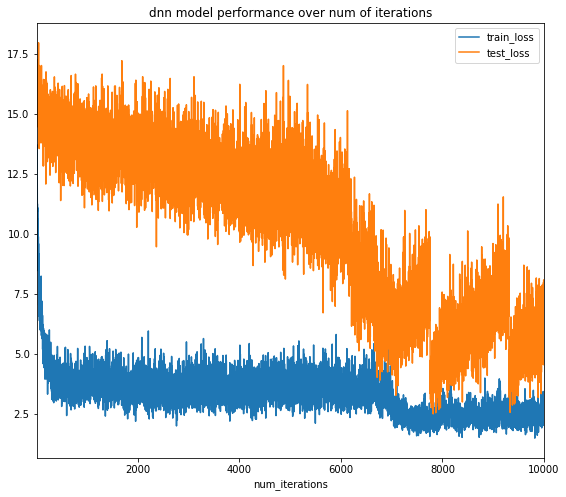

In [23]:
start_time = timeit.default_timer()
dnn_model_2.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

In [29]:
book_id = 104081
neighbors_df_2 = book_neighbors(books, dnn_model_2, book_id, measure='cosine', k=10)
neighbors_df_2.sort_values(['cosine score'], ascending=False)[:10]

Nearest neighbors of : The Da Vinci Code (Robert Langdon, #2).


,cosine score,book_id,titles,is_ebook,average_rating,ratings_count
98520,1.0,104081,"The Da Vinci Code (Robert Langdon, #2)",0,3.79,1465770
94416,0.9973840713500977,91271,Fear the Worst,0,3.87,67
17253,0.9968851804733276,9488,"All Necessary Force (Pike Logan, #2)",1,4.16,958
36713,0.9967859983444214,31087,Dark Paradise,0,3.06,41
65983,0.9964902997016907,30994,The Asylum,1,3.4,186
5370,0.9960483312606812,27912,"Fall Guy (Rachel Alexander & Dash, #7)",0,3.99,16
104980,0.9948335886001587,97249,"Pretty Little Liars (Pretty Little Liars, #1)",1,3.9,2533
33475,0.9948229193687439,16764,The Brotherhood of the Holy Shroud,0,3.48,2805
64570,0.9943198561668396,83373,"Void Moon (Harry Bosch Universe, #12)",0,3.95,314
78489,0.9938554763793945,96483,"The Reversal (Harry Bosch, #16; Mickey Haller,...",0,4.13,35649
